# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import pickle
import copy
import nltk
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer   # Turning textual data into numeric for computation
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.impute import KNNImputer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import defaultdict
from sklearn.metrics import confusion_matrix           
from sklearn.metrics import classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mtahi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### ***READING CSV AND TOKENIZING***

#### *READING DATA TRAIN.CSV*

In [2]:
# Function to load the training dataset
def get_training_dataset():
    labels = ["country", "id", "title", "category1", "category2", "category3", "description", "price", "type"]
    return pd.read_csv('data_train.csv', header=None, names=labels)

# Function for feature selection and concatenation
def feature_selection(df):
    df.drop(["country", "id", "price", "type"], inplace=True, axis=1)
    df['titleDescp'] = df['title'] + " " + df['description']
    df.drop(['title', 'description'], inplace=True, axis=1)
    return df, df['category1'], df['category2'], df['category3']

# Function for preprocessing text data
def pre_processing(content):
    ps = PorterStemmer()
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    stemmed_content = re.sub('[^a-zA-Z]', ' ', str(content))
    stemmed_content = re.sub(CLEANR, '', stemmed_content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    return ' '.join(stemmed_content)

# Function to preprocess the entire dataset
def cleaning_data_utility(training_df):
    X, Y1, Y2, Y3 = feature_selection(training_df)
    X['titleDescp'] = X['titleDescp'].apply(pre_processing)
    return X, Y1, Y2, Y3

# Function to print statistics about missing values
def null_statistics(df):
    missing_val = df.isnull().sum()
    total_cells = np.prod(df.shape)
    missing_percent = (missing_val.sum()/total_cells) * 100
    print(f'The missing data percent is: {missing_percent}')

# Function to preserve unique labels for each category
def preserve_label(train_df):
    return train_df['category1'].unique(), train_df['category2'].unique(), train_df['category3'].unique()

# Utility function to encode categorical data using LabelEncoder
def encode_utility(data):
    encoder = LabelEncoder()
    nonulls = np.array(data.dropna())
    impute_ordinal = encoder.fit_transform(nonulls) 
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

# Function to encode categorical columns
def encode(target, train_df):
    for columns in target:
        encode_utility(train_df[columns])

# Function to impute missing values using KNN imputer
def impute(train_df):
    imputer = KNNImputer()
    return np.round(imputer.fit_transform(train_df[['category1', 'category2', 'category3']]))

# Function to clean the CSV file and save the cleaned data
def clean_csv(df, train_df):
    df = pd.DataFrame(df, columns=['category1', 'category2', 'category3'])
    df['Title_desc'] = train_df['titleDescp']
    df.to_csv('train_clean.csv', index=False, header=True)
    return df

# Load the training dataset
training_dataset = get_training_dataset()

# Perform cleaning and preproce
ssing on the dataset
train_df, Y1, Y2, Y3 = cleaning_data_utility(training_dataset)
null_statistics(train_df)

# Preserve unique labels for each category
unique_label_c1, unique_label_c2, unique_label_c3 = preserve_label(train_df)

# Encode categorical columns
encode(['category1', 'category2', 'category3'], train_df)

# Impute missing values
train_df_imputed = impute(train_df)

# Clean the CSV file and save the cleaned data
train_df_imputed = clean_csv(train_df_imputed, train_df)

# Print statistics about missing values in the cleaned dataset
null_statistics(train_df_imputed)


The missing data percent is: 1.4710746079431138
The missing data percent is: 0.0


#### *Unique Labels in Categories*

In [3]:
print("Unique Labels in Cateogry 1: ",len(unique_label_c1))
print("Unique Labels in Cateogry 2: ",len(unique_label_c2))
print("Unique Labels in Cateogry 3: ",len(unique_label_c3))

Unique Labels in Cateogry 1:  9
Unique Labels in Cateogry 2:  57
Unique Labels in Cateogry 3:  185


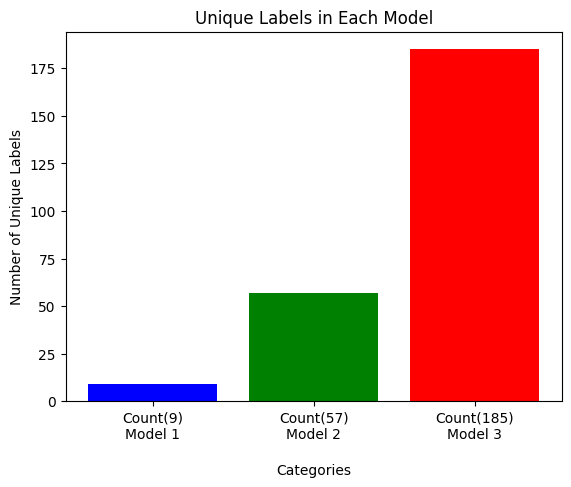

In [4]:
# Labels for the bar plot
labels = [f'Count({len(unique_label_c1)})\nModel 1', 
          f'Count({len(unique_label_c2)})\nModel 2', 
          f'Count({len(unique_label_c3)})\nModel 3']

# Counts of unique labels for each model
counts = [len(unique_label_c1), len(unique_label_c2), len(unique_label_c3)]

# Creating the bar plot
plt.bar(labels, counts, color=['blue', 'green', 'red'])

# Adding labels to the axes
plt.xlabel('\nCategories')
plt.ylabel('Number of Unique Labels')

# Adding a title to the plot
plt.title('Unique Labels in Each Model')

# Displaying the plot
plt.show()


### ***FEATURE ENGINEERING***

In [5]:
# Extracting features (Title_desc) and target labels (category1, category2, category3)
X = train_df_imputed['Title_desc']  # Features
Y1 = train_df_imputed['category1']   # Target labels for model 1
Y2 = train_df_imputed['category2']   # Target labels for model 2
Y3 = train_df_imputed['category3']   # Target labels for model 3

# Initializing and fitting the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

# Transforming the input features into TF-IDF matrix
X_tfidf = vectorizer.transform(X)


#### *Plot 5 Rows of Selected Data*

In [6]:
from IPython.display import display, HTML

def decode_model(number, unique_labels):
    le = LabelEncoder()
    le.fit(unique_labels)
    return str(le.inverse_transform(number))

# Create a new DataFrame with the selected columns
df = train_df_imputed[['Title_desc']].copy()

# Add the decoded categories to the DataFrame
df['Category1'] = decode_model(Y1.values.astype(int), unique_label_c1)
df['Category2'] = decode_model(Y2.values.astype(int), unique_label_c2)
df['Category3'] = decode_model(Y3.values.astype(int), unique_label_c3)

# Display the DataFrame with the decoded categories
display(HTML(df.head().to_html().replace('<th>', '<th style="font-weight: bold; border: 1px solid black;">').replace('<td>', '<td style="border: 1px solid black;">')))

### ***MODEL TRAINING***

### *TRAIN MODEL* 1 

In [7]:
# Fit the model on the entire dataset
SVM_Classfier = SVC(kernel='linear', random_state=0)
model1 = SVM_Classfier.fit(X_tfidf, Y1)

### *SAVE MODEL 1*

In [8]:
pickle.dump(model1, open('Models/model_1.pickle', 'wb'))

### *TRAIN MODEL 2* 

In [9]:
# Fit the model on the entire dataset
SVM_Classfier = SVC(kernel='linear', random_state=0)
model2 = SVM_Classfier.fit(X_tfidf, Y2)

### *SAVE MODEL 2*

In [10]:
pickle.dump(model2, open('Models/model_2.pickle', 'wb'))

### *TRAIN MODEL 3*

In [11]:
# Fit the model on the entire dataset
SVM_Classfier = SVC(kernel='linear', random_state=0)
model3 = SVM_Classfier.fit(X_tfidf, Y3)

### *SAVE MODEL 3*

In [12]:
pickle.dump(model3, open('Models/model_3.pickle', 'wb'))

### ***MODEL TESTING***

#### *READING DATA VALID.CSV*

In [13]:
# Define column labels for the testing dataset
labels=["country", "id", "title", "category1","category2","category3", "description", "price", "type"]

# Read the testing dataset from 'data_valid.csv'
testingDataset = pd.read_csv('data_valid.csv' , header=None, names=labels)

# Clean and preprocess the testing dataset
test_df, Y1, Y2, Y3 = cleaning_data_utility(testingDataset)

# Print statistics about missing values in the testing dataset
null_statistics(test_df)

# Preserve unique labels for each category in the testing dataset
unique_label_c1, unique_label_c2, unique_label_c3 = preserve_label(test_df)

# Encode categorical columns in the testing dataset
encode(['category1', 'category2', 'category3'], test_df)

# Impute missing values in the testing dataset
test_df_imputed = impute(test_df)

# Clean the CSV file and save the cleaned testing dataset
test_df_imputed = clean_csv(test_df_imputed, test_df)

# Print statistics about missing values in the cleaned testing dataset
null_statistics(test_df_imputed)


The missing data percent is: 1.4508362899138367
The missing data percent is: 0.0


#### *FEATURE ENGINEERING*

In [14]:
X = test_df_imputed['Title_desc']
Y1 = test_df_imputed['category1']
Y2 = test_df_imputed['category2']
Y3 = test_df_imputed['category3']

x_test_tfidf = vectorizer.transform(X)

#### *SAVE VECTORIZER*

In [15]:
pickle.dump(vectorizer, open("Models/vectorizer.pickle", "wb"))

### ***MODEL 1 PREDICTION***

In [16]:
# Predict the test set results
y_pred_cat_1 = model1.predict(x_test_tfidf)

### MODEL 1 EVALUATIONS ON TEST DATA

In [17]:
# Accuracy
accuracy = metrics.accuracy_score(Y1, y_pred_cat_1)
print(f"Accuracy: {accuracy*100:.2f}%")

# Precision, Recall, F1-score
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y1, y_pred_cat_1, average='weighted')
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")

print("Classification Report:")
print(classification_report(Y1, y_pred_cat_1))

Accuracy: 93.05%
Precision: 93.13%
Recall: 93.05%
F1 Score: 93.05%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       646
         1.0       0.92      0.89      0.91       965
         2.0       0.96      0.96      0.96      1855
         3.0       0.94      0.94      0.94      1339
         4.0       0.87      0.93      0.90      1993
         5.0       0.94      0.83      0.88       525
         6.0       0.95      0.96      0.96      2328
         7.0       0.86      0.85      0.85       824
         8.0       0.97      0.95      0.96      1363

    accuracy                           0.93     11838
   macro avg       0.93      0.91      0.92     11838
weighted avg       0.93      0.93      0.93     11838



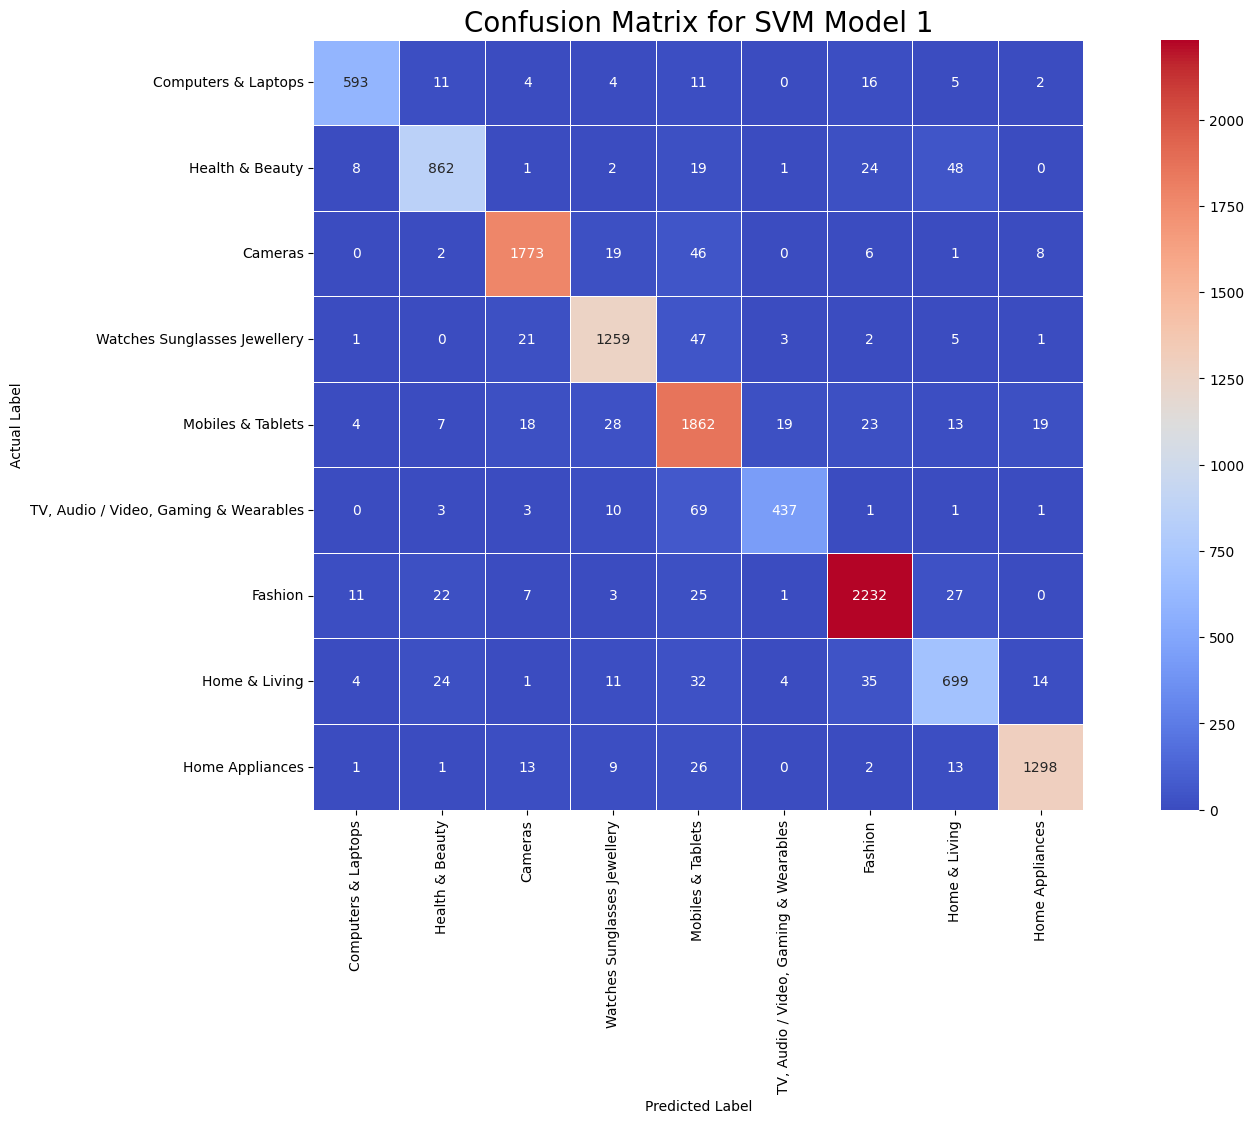

In [18]:
cf_matrix = confusion_matrix(Y1, y_pred_cat_1)

# Create a new figure with a custom size
plt.figure(figsize=(20,10))

# Create a heatmap with a different color map and other properties
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='coolwarm', square=True, cbar=True, linewidths=.5, xticklabels=unique_label_c1, yticklabels=unique_label_c1)

# Set the labels for the x and y axis
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Set the title for the plot
plt.title('Confusion Matrix for SVM Model 1', fontsize=20)

# Show the plot
plt.show()

### ***MODEL 2 PREDICTION***

In [19]:
# Predict the test set results
y_pred_cat_2 = model2.predict(x_test_tfidf)

### MODEL 2 EVALUATIONS ON TEST DATA

In [20]:
# Accuracy
accuracy = metrics.accuracy_score(Y2, y_pred_cat_2)
print(f"Accuracy: {accuracy*100:.2f}%")

# Precision, Recall, F1-score
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y2, y_pred_cat_2, average='weighted')
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")

print("Classification Report:")
print(classification_report(Y2, y_pred_cat_2))

Accuracy: 86.42%
Precision: 86.74%
Recall: 86.42%
F1 Score: 86.27%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2206
         1.0       0.84      0.86      0.85       381
         2.0       0.84      0.69      0.76        78
         3.0       0.68      0.68      0.68       111
         4.0       0.78      0.68      0.73       144
         5.0       0.94      0.94      0.94       124
         6.0       0.81      0.59      0.68        22
         7.0       0.86      0.83      0.85       256
         8.0       0.86      0.82      0.84       485
         9.0       0.97      0.90      0.94        41
        10.0       0.96      0.89      0.93       114
        11.0       0.88      0.74      0.80        19
        12.0       0.93      0.74      0.82        38
        13.0       0.88      0.74      0.80        19
        14.0       0.94      0.97      0.96       146
        15.0       0.87      0.85      0.86  

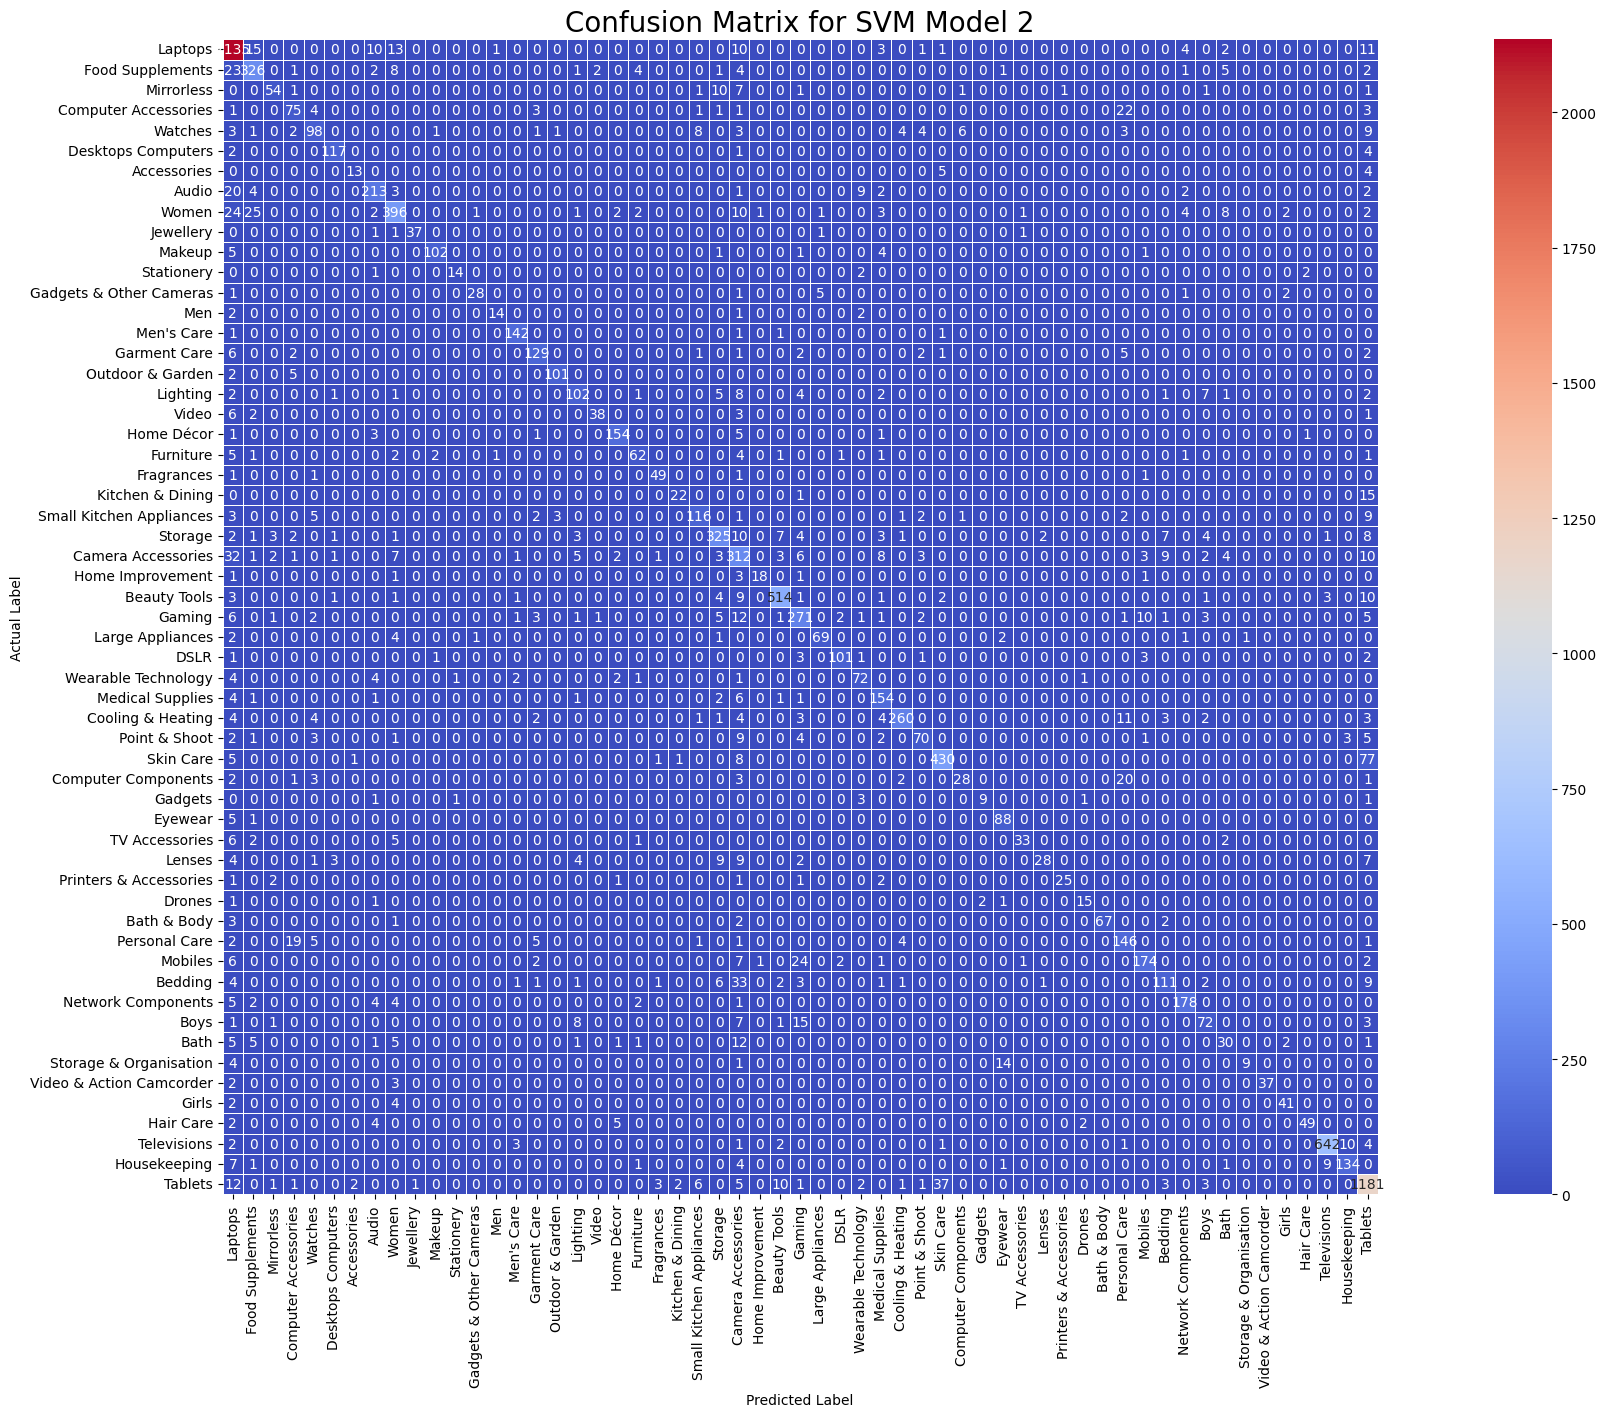

In [21]:
cf_matrix = confusion_matrix(Y2, y_pred_cat_2)

# Create a new figure with a custom size
plt.figure(figsize=(30,15))

# Create a heatmap with a different color map and other properties
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='coolwarm', square=True, cbar=True, linewidths=.5, xticklabels=unique_label_c2, yticklabels=unique_label_c2)

# Set the labels for the x and y axis
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Set the title for the plot
plt.title('Confusion Matrix for SVM Model 2', fontsize=20)

# Show the plot
plt.show()

### ***MODEL 3 PREDICTION***

### MODEL 3 EVALUATIONS ON TEST DATA

In [22]:
# Predict the test set results
y_pred_cat_3 = model3.predict(x_test_tfidf)

In [23]:
# Accuracy
accuracy = metrics.accuracy_score(Y3, y_pred_cat_3)
print(f"Accuracy: {accuracy*100:.2f}%")

# Precision, Recall, F1-score
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y3, y_pred_cat_3, average='weighted')
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")

print("\nClassification Report:")
print(classification_report(Y3, y_pred_cat_3))

Accuracy: 76.78%
Precision: 80.55%
Recall: 76.78%
F1 Score: 77.70%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.67      0.75        18
         1.0       0.79      0.80      0.80       187
         2.0       0.61      0.65      0.62        31
         3.0       0.65      0.75      0.70        40
         4.0       1.00      0.74      0.85        19
         5.0       0.97      0.92      0.94        36
         6.0       0.75      0.24      0.37        37
         7.0       0.35      0.65      0.46        20
         8.0       0.44      0.42      0.43        45
         9.0       0.90      0.93      0.92       283
        10.0       0.75      0.78      0.77        55
        11.0       0.88      0.33      0.48        21
        12.0       0.80      0.70      0.75        40
        13.0       0.74      0.61      0.67        23
        14.0       0.61      0.66      0.63       141
        15.0       0.94      0.85      0.89 

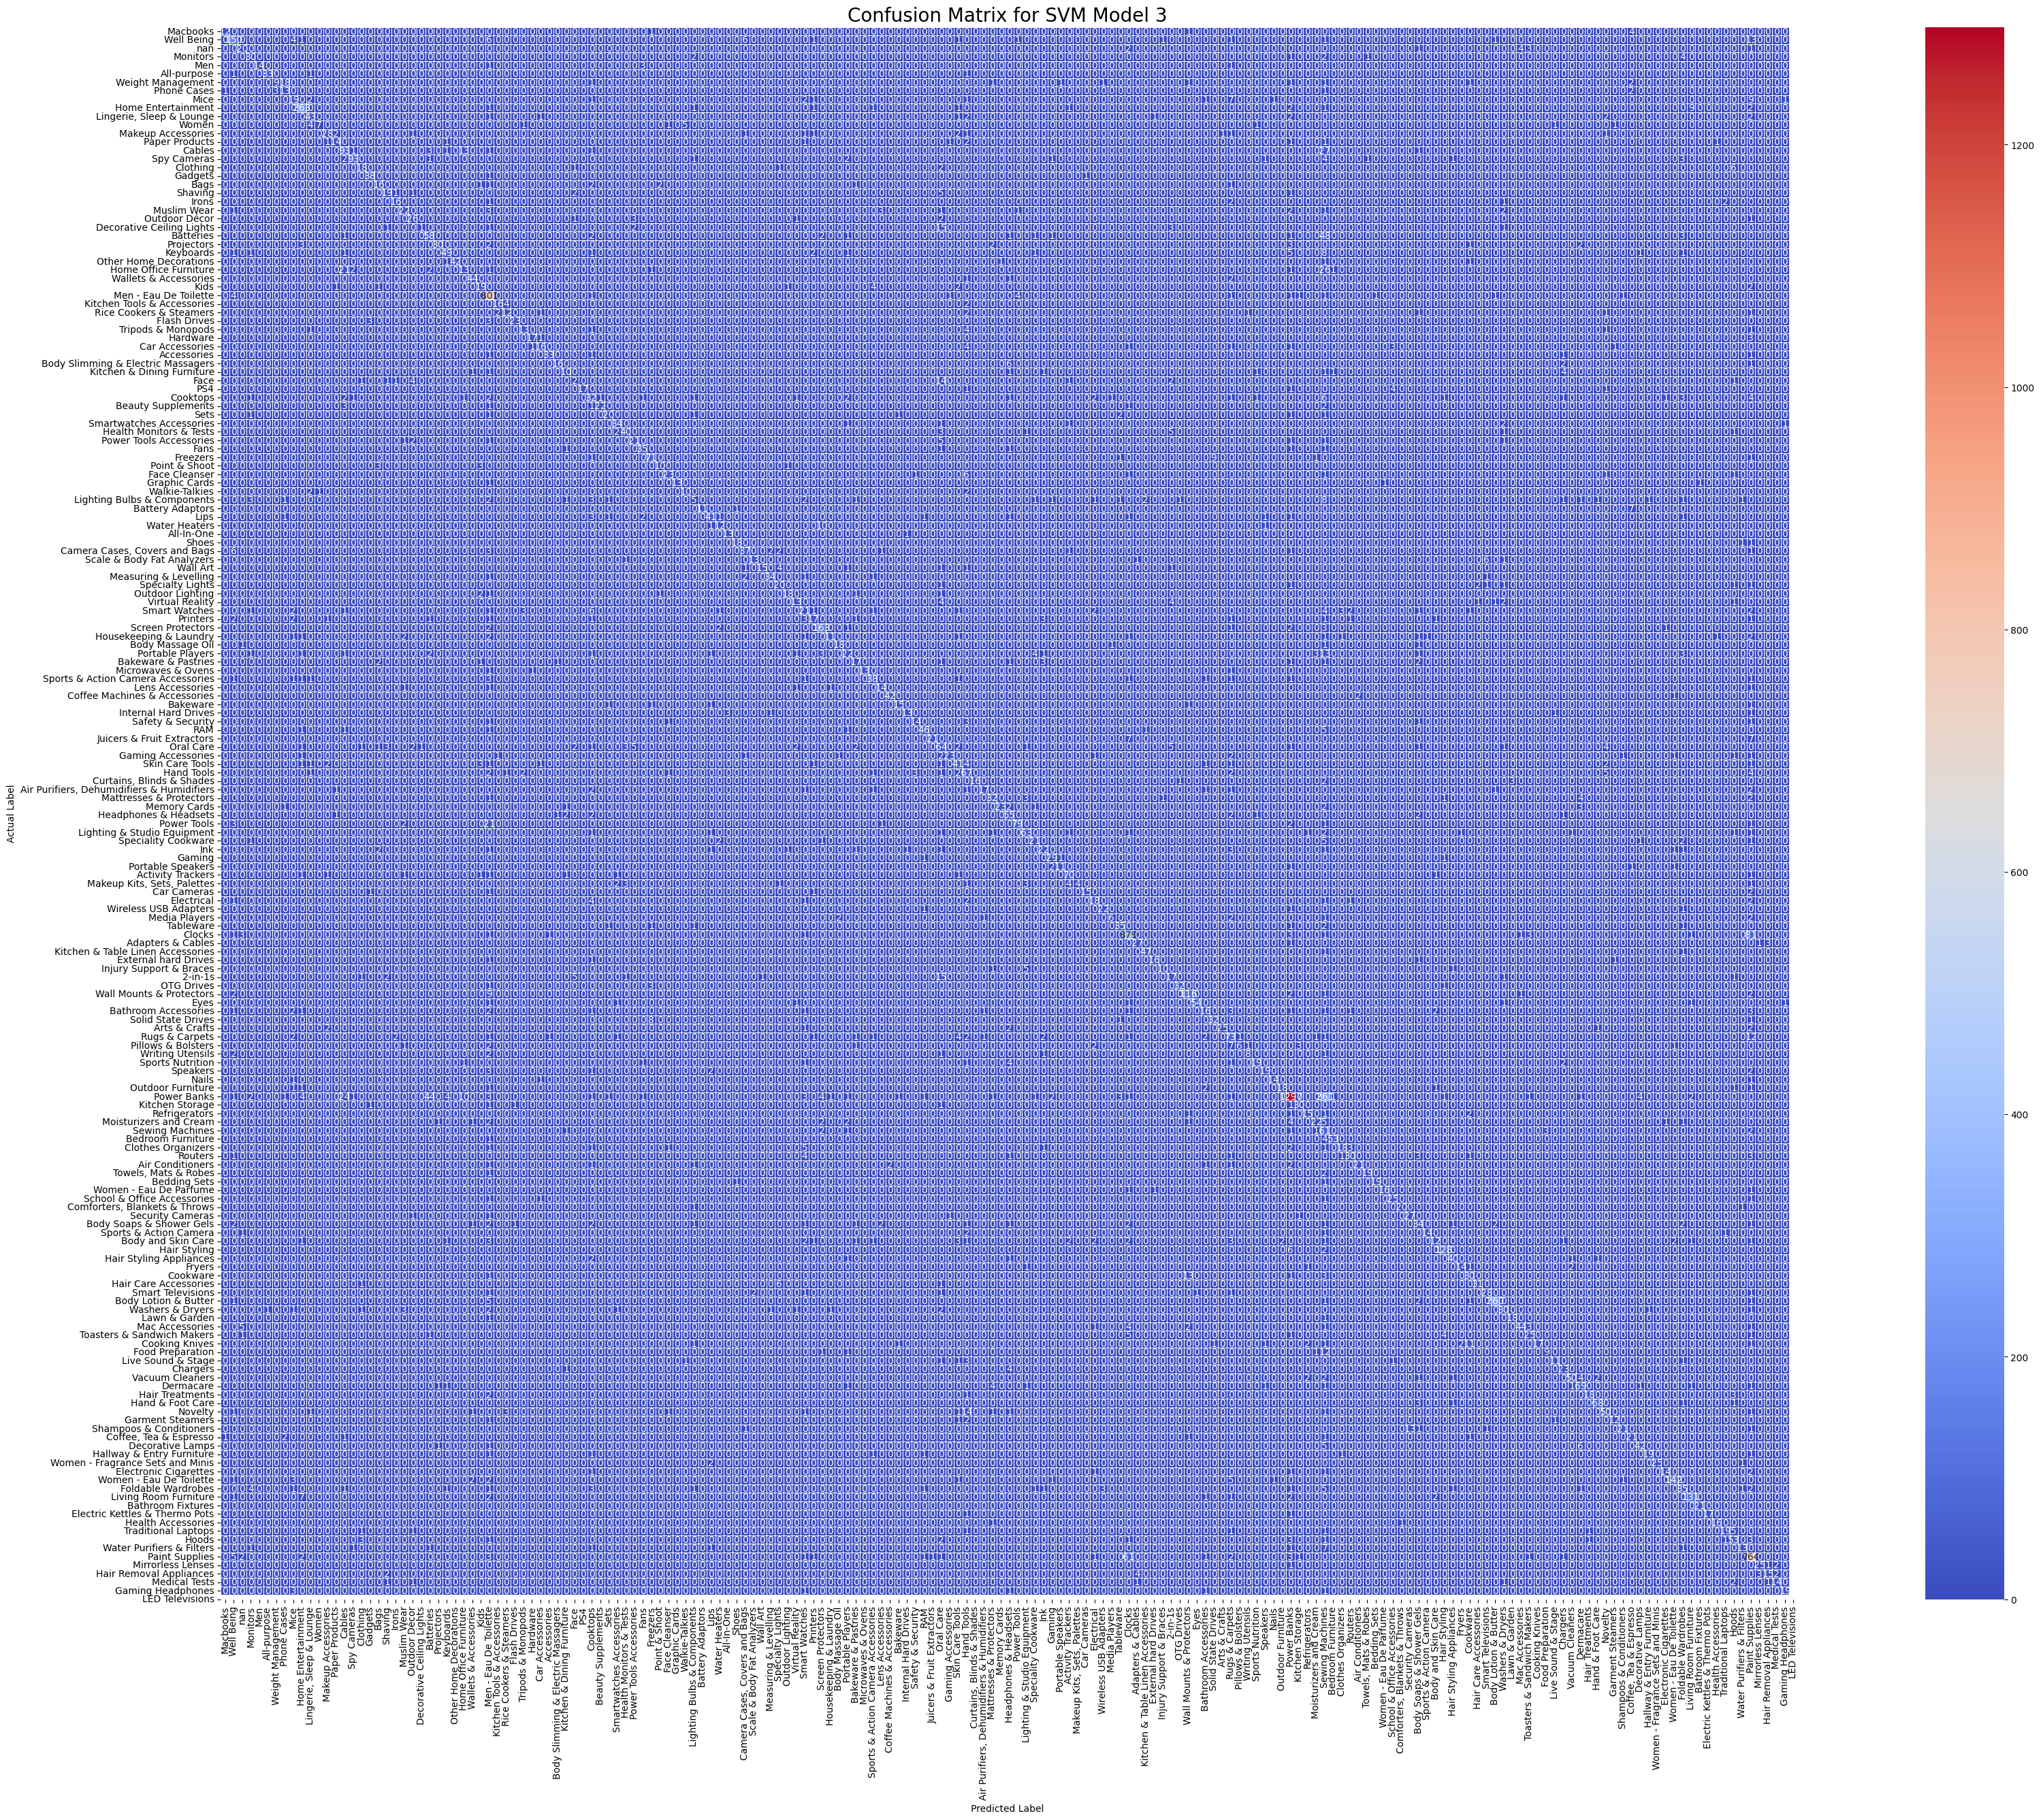

In [24]:
cf_matrix = confusion_matrix(Y3, y_pred_cat_3)

# Create a new figure with a custom size
plt.figure(figsize=(50,30))

# Create a heatmap with a different color map and other properties
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='coolwarm', square=True, cbar=True, linewidths=.5, xticklabels=unique_label_c3, yticklabels=unique_label_c3)

# Set the labels for the x and y axis
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Set the title for the plot
plt.title('Confusion Matrix for SVM Model 3', fontsize=20)

# Show the plot
plt.show()

### ***QUERY TESTING***

### ***DECODE MODELS***

In [25]:
def decode_model(number, unique_labels):
    le = LabelEncoder()
    le.fit(unique_labels)
    return str(le.inverse_transform([number]))

### ***Load Models & Predict Title***

In [26]:
# Load models
model_c1_svm = pickle.load(open('Models/model_1.pickle', 'rb'))
model_c2_svm = pickle.load(open('Models/model_2.pickle', 'rb'))
model_c3_svm = pickle.load(open('Models/model_3.pickle', 'rb'))

# Load vectorizer 
tfidf_vectorizer = pickle.load(open('Models/vectorizer.pickle','rb'))

def Predict_Query_SVM(query):
    # Transform the query using the vectorizer trained on the corpus
    query_tfidf_matrix = tfidf_vectorizer.transform(query)
    
    m1 = model_c1_svm.predict(query_tfidf_matrix)
    m2 = model_c2_svm.predict(query_tfidf_matrix)
    m3 = model_c3_svm.predict(query_tfidf_matrix)
    
    return m1, m2, m3

In [27]:
query="Pumice Stone Cleaning Pumice Stone for Toilet Cleaning Powerhouse Pumice Sticks Stone Grill Cleaner for Removing Toilet Bowl Ring, Bath, Household, Kitchen, Pool"
query=pre_processing(query)

m1,m2,m3=Predict_Query_SVM([query])
Ctg1=decode_model(int(m1[0]),unique_label_c1)
Ctg2=decode_model(int(m2[0]),unique_label_c2)
Ctg3=decode_model(int(m3[0]),unique_label_c3)

print("Query: ", query)
print("Category 1: ", Ctg1)
print("Category 2: ", Ctg2)
print("Category 3: ", Ctg3)

Query:  pumic stone clean pumic stone toilet clean powerhous pumic stick stone grill cleaner remov toilet bowl ring bath household kitchen pool
Category 1:  ['Home & Living']
Category 2:  ['Home Improvement']
Category 3:  ['Housekeeping & Laundry']
